<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Image Explainability using XWhy</b></div>

<a id="1.2"></a>
<h2 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #155D07; background-color: #ffffff;"><b>Comparing</b> Image Exlainability of XWhy with LIME and BayLIME</h2>

<p style="text-align: justify;">With the ever-increasing complexity of machine learning models, explainability has become an indispensable element of effective data analysis. Sophisticated algorithms like deep learning can offer tremendous predictive power, but their "black box" nature can obscure understanding and limit their practical application. Hence, the demand for tools and techniques that elucidate the decision-making processes of these models has grown significantly. Among the tools that have emerged to tackle this issue, model-agnostic approaches like Local Interpretable Model-Agnostic Explanations (LIME) and Bayesian Local Interpretable Model-Agnostic Explanations (BayLIME) have made substantial contributions. They provide localized explanations of predictions, offering insights into how and why a specific prediction was made, thus boosting the transparency and interpretability of complex models.</p>

<p style="text-align: justify;">However, as the field of explainability continues to evolve, the quest for superior methods remains unquenched. Our paper introduces a novel approach, X-Why, designed to enhance the explainability of machine learning models beyond the capabilities of existing methods utilizing statistical distance measures like Wasserstein. X-Why aims to improve the interpretability gap left by traditional methods like LIME and BayLIME, taking the science of model explainability a step further. The intent is to provide more comprehensive, intuitive, and robust interpretations of predictions, thus enabling more informed decision-making in software systems. This study aims to present a comparative analysis of X-Why with existing model-agnostic approaches to demonstrate its potential benefits and improvements over other techniques in the field of explainable artificial intelligence.</p>

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Table of content</b></div>

<div style="background-color:aliceblue; padding:30px; font-size:15px;color:#034914">
    
* [Import Libraries](#lib)
* [Step-by-Step Implementation of LIME](#step_LIME) 
* [Defining LIME Function](#LIME)
* [Defining XWhy Function with Wasserstein Distance](#xwhy_wd)
* [Comparing XWhy with LIME](#comp_LIME)
* [Comparing XWhy with BayLIME](#comp_BayLIME)
* [Defining XWhy Function with Anderson Darling Distance](#xwhy_add)
* [Defining XWhy Function with Kolmogorov Smirnov Distance](#xwhy_ksd)
* [Comparing XWhy with SHAP (Under Construction :D)](#comp_SHAP)
* [References](#ref)

<a id="2"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Import libraries</b></div>

In [1]:
import numpy as np
import torch
from torchvision import transforms
import skimage.io 
import skimage.segmentation
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

from PIL import Image, ImageDraw
import json
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm

print('Notebook running: pytorch ', torch.__version__)
np.random.seed(222)

Notebook running: pytorch  2.0.0+cpu


The first step is to import a model that we would like I) to use for image classification and II) to test for explainabiity.

In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 239MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

The second step is to import the image and resize it for to be used as an input for the model.

In [3]:
in_image = "/kaggle/input/input-image/cat-and-dog.jpg"
annotation_file = "/kaggle/input/annotations1/temp-bothimg_json.json"

In [4]:
input_image = Image.open(in_image)
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

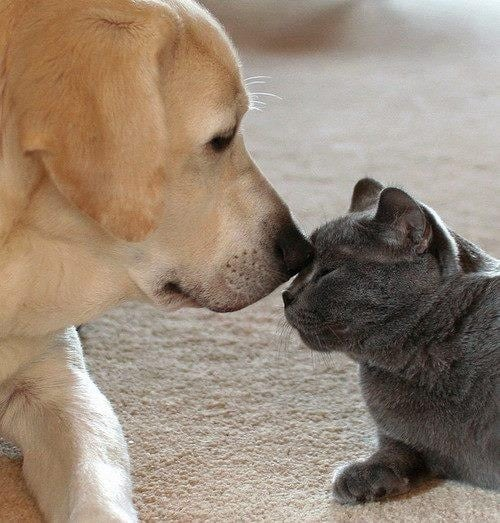

In [5]:
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
input_image

In [6]:
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

In [7]:
def get_annotations(img_path, annot_path):
    im = Image.open(img_path)
    width, height = im.size
    im_name = img_path.split('/')[-1]
    img_bundle = ['5.jpg229955', 'cat-and-dog.jpg55457']
    if im_name in img_bundle[0]:
        im_name = img_bundle[0]
    elif im_name in img_bundle[1]:
        im_name = img_bundle[1]
    else:
        raise TypeError("Bundle not found.")
        
    load_json = json.load(open(annot_path))
    
    # Define colors DO NOT CHANGE
    bg_color = (128, 128, 128)
    c1_color = (0, 255, 200)
    c2_color = (0, 0, 200)
    col_list = [c1_color, c2_color]
    
    labels = []
    classes = []
    for i in range(len(load_json[im_name]['regions'])):
        classes.append(load_json[im_name]['regions'][i]['region_attributes']['name'].rstrip())
        labels.append(load_json[im_name]['regions'][i]['shape_attributes'])
    
    polygons = []
    for i in range(len(labels)):
        Y = labels[i]['all_points_y']
        X = labels[i]['all_points_x']
        poly = []
        for x, y in zip(X,Y):
            poly.append((x, y))
        polygons.append(poly)
    
    image = Image.new("RGB", im.size, bg_color)
    draw = ImageDraw.Draw(image)
    for i in range(len(polygons)):
        draw.polygon(polygons[i], fill=col_list[i])
    sem_mask = np.full((height, width), 0)
    image_np = np.array(image)
    image_np.shape, sem_mask.shape
    for i in range(image_np.shape[0]):
        for j in range(image_np.shape[1]):
            if image_np[i, j, 1] == bg_color[1]:
                sem_mask[i, j] = 0
            elif image_np[i, j, 1] == c1_color[1]:
                sem_mask[i, j] = 1
            elif image_np[i, j, 1] == c2_color[1]:
                sem_mask[i, j] = 2
    return image, sem_mask

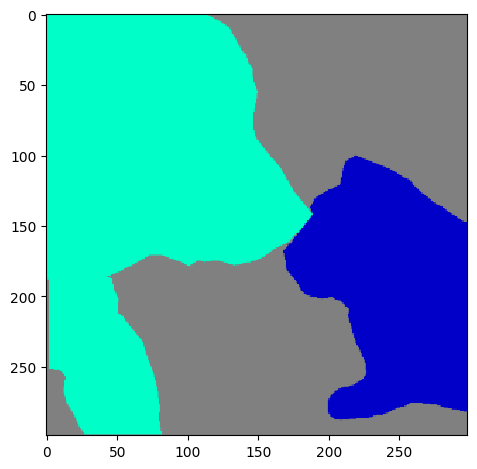

In [8]:
image_annotated, sem_mask = get_annotations(in_image, annotation_file)
seman_transformed = skimage.transform.resize(sem_mask, (299,299), preserve_range=True).astype('uint8')
im_np = np.array(image_annotated)
image_annotated = skimage.transform.resize(im_np, (299,299)) 
# image_annotated = (image_annotated - 0.5)*2 #Inception pre-processing
# skimage.io.imshow(image_annotated/2+0.5) # Show image before inception preprocessing
skimage.io.imshow(image_annotated) # Show image before inception preprocessing

In [9]:
# sem_mask consists of pixel-wise numbers from 0 to 2. 0: others, 1: dog, 2: cat
np.min(seman_transformed), np.max(seman_transformed)

(0, 2)

In [10]:
with torch.no_grad():
  output = model(input_batch)
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

In [11]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2023-10-04 12:45:33--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-10-04 12:45:33 (39.7 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [12]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Labrador retriever 0.7126777768135071
golden retriever 0.019066933542490005
Great Pyrenees 0.011683483608067036
kuvasz 0.009549546055495739
American Staffordshire terrier 0.007769784890115261


In [13]:
Xi = input_batch.squeeze().permute(1, 2, 0).numpy()

In [14]:
np.min(Xi), np.max(Xi)

(-0.9843137, 1.0)

In [15]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

62

In [16]:
np.unique(superpixels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])

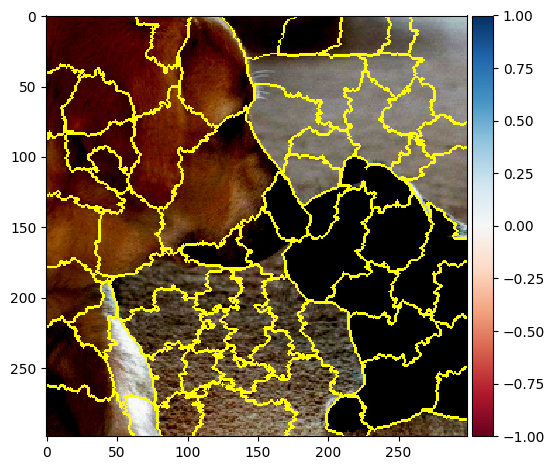

In [17]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi, superpixels))

In [18]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

In [19]:
def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
          mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

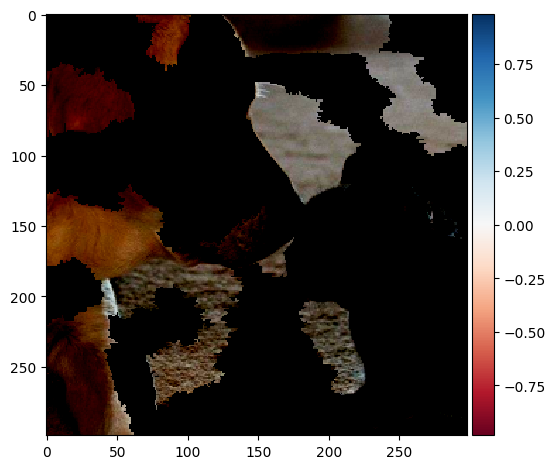

In [20]:
skimage.io.imshow(perturb_image(Xi,perturbations[0],superpixels))

In [21]:
def preprocess_numpy(np_array):
    '''
    Takes numpy image array as an input.
    Applies the transformation and convert
    returns pytorch tensor with batch 1. 
    '''
    transformed_tensor = None
    #if np.max(np_array ) != 1:
    #    transformed_tensor = (np_array - 0.5)*2 #Inception pre-processing
    #transformed_tensor = np_array.
    #transformed_tensor = torch.tensor(transformed_tensor).double()
    transformed_tensor = np_array.transpose(2, 0, 1)
    transformed_tensor = torch.tensor(transformed_tensor).double()
    return transformed_tensor.unsqueeze(0)
        

In [22]:
predictions = None
model = model.double()
for pert in tqdm(perturbations):
    perturbed_img = perturb_image(Xi,pert,superpixels)
    in_batch = preprocess_numpy(perturbed_img)
    with torch.no_grad():
        pred = model(in_batch)
    if predictions is None:
        predictions = pred.detach().cpu().unsqueeze(0).numpy()
    else:
        predictions = np.concatenate((predictions, pred.detach().cpu().unsqueeze(0).numpy()), 0)
predictions.shape

100%|██████████| 150/150 [00:56<00:00,  2.66it/s]


(150, 1, 1000)

In [23]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [24]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [25]:
class_to_explain = top5_catid[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.45407961,  0.45728366,  0.3184621 ,  0.89934762,  0.30897376,
        0.29492154, -0.22945602,  3.55567881, -0.12123084,  0.26790131,
       -0.17403628,  0.31184535,  0.1825909 ,  0.8641722 , -0.31829024,
        0.43125061,  0.27413917, -0.15222274, -0.09347514, -0.01335637,
        0.07638316, -0.33145213, -0.54947308,  0.18505345,  0.17676832,
        3.91754218,  0.24442531,  0.19912097, -0.1150961 ,  0.48066225,
        0.1203289 , -0.40224572,  0.35103929, -0.1361994 ,  0.28054833,
        0.47614814, -0.27350843, -0.671091  ,  0.02537647, -0.35866001,
       -0.09646145,  0.68242821, -0.35243665,  0.1888421 ,  0.12005707,
       -0.06003848, -0.44934721,  0.05511793, -0.6495667 ,  0.82081456,
        0.41683646,  0.71293272,  0.18808223, -0.29813101, -0.63291371,
       -0.02116412, -0.21062067,  0.571463  , -0.24814139, -0.10646998,
        0.5412467 , -0.14385158])

In [26]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([13,  3,  7, 25])

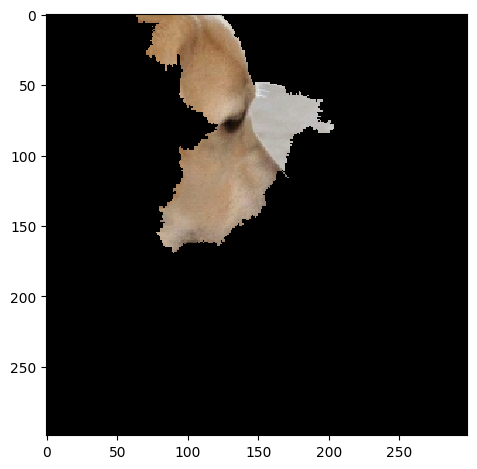

In [27]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

<a id="LIME"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Defining LIME Function</b></div>
Here the LIME function is defined as "xwhy_image".

In [28]:
def xwhy_image(X_input, model, num_perturb = 150, kernel_width = 0.25):
    
    superpixels = skimage.segmentation.quickshift(X_input, kernel_size=4, max_dist=200, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    
    def perturb_image(img,perturbation,segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
              mask[segments == active] = 1 
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image
    
    predictions = None
    for pert in tqdm(perturbations):
        perturbed_img = perturb_image(X_input,pert,superpixels)
        in_batch = preprocess_numpy(perturbed_img)
        with torch.no_grad():
            pred = model(in_batch)
        if predictions is None:
            predictions = pred.detach().cpu().unsqueeze(0).numpy()
        else:
            predictions = np.concatenate((predictions, pred.detach().cpu().unsqueeze(0).numpy()), 0)
    
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    
    class_to_explain = top5_catid[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
        
    return coeff, perturbations

In [29]:
Xi.shape, np.min(Xi), np.max(Xi)

((299, 299, 3), -0.9843137, 1.0)

100%|██████████| 150/150 [00:57<00:00,  2.62it/s]


62
CPU times: user 1min 44s, sys: 12.3 s, total: 1min 56s
Wall time: 58.8 s


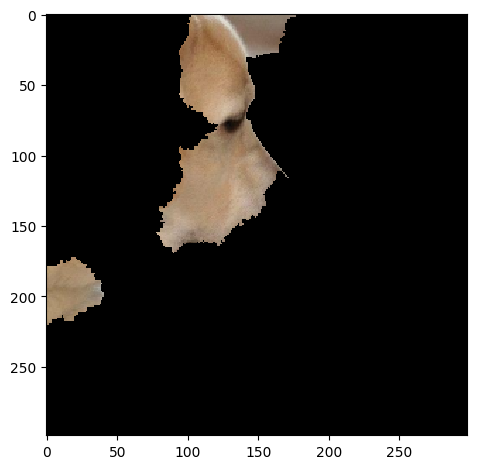

In [30]:
%%time
coeff, perturbations = xwhy_image(Xi, model=model)

print(len(coeff))

num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels))

#### Coverage estimation
Here, to quantify the coverage, a simple coverage estimation is used. 

$$ coverage = \frac{\sum_{x=1, y=1}^{w, h}[X_{x,y} > 0 \cap M_{x,y} = coi]- \sum_{x=1,y=1}^{w,h}[X_{x,y} > 0 \cap 
 M_{x,y}\neq coi]}{\sum_{x=0, y=0}^{w,h} M_{x,y}=coi} $$

where, 
* $x$ number of pixel in X-direction for an image of width $w$
* $y$ number of pixel in Y-direction for an image of height $h$
* $X$ the explaination
* $M$ Ground truth
* $coi$ class of interest

#### Weighted-Coverage estimation
To further take into account weight, we quantify the coverage, with a weighted coverage estimation. For that, first modify the label as following:

$$ M_{x,y} = \begin{cases}
1 & \text{ if } M_{x,y} = coi\\ 
-1 & \text{ if } M_{x,y} \neq  coi 
\end{cases} \forall  0 \leqslant x \leqslant w, 0 \leqslant y \leqslant h  $$

which can be used to obtain the weighted coverage as: 

$$ coverage_w = \frac{\sum_{x=1, y=1}^{w, h}[X_{x,y} * M_{x,y} ]}{w*h} $$

where, 
* $X$ the explaination
* $x$ number of pixel in X-direction for an image of width $w$
* $y$ number of pixel in Y-direction for an image of height $h$
* $M$ Ground truth
* $coi$ class of interest

In [31]:
# Compute percentage of true label covered by the exmplainer
def get_coverage(input_im, mask, coi=1):
    # coi : Class of interest, here default is set to dog
    tot = 0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if sum(input_im[i,j]) > 0:
                if mask[i,j] == coi:
                    tot += 1
                else:
                    tot -= 1
    cov = tot/np.count_nonzero(mask ==coi )
    return cov
    

In [32]:
# Compute weighted percentage of true label covered by the exmplainer
def get_weighted_coverage(input_im, mask, coi=1):
    # coi : Class of interest, here default is set to dog
    copy_mask = np.copy(seman_transformed).astype('float')
    np.place(copy_mask, copy_mask==0, -1)
    np.place(copy_mask, copy_mask==2, -1)
    tot = 0
    for i in range(copy_mask.shape[0]):
        for j in range(copy_mask.shape[1]):
            tot += input_im[i,j] * copy_mask[i,j]
    w_cov = tot/(copy_mask.shape[0]*copy_mask.shape[1])
    return w_cov

In [33]:
a = perturb_image(Xi/2+0.5,mask,superpixels)
cov = get_coverage(a, seman_transformed)
print("The coverage with the true label is : ", cov)

The coverage with the true label is :  0.22770537413969835


In [34]:
def create_heat_mask(superpixels_b, coeff):
    # Initialize an empty image
    heat_mask = np.zeros_like(superpixels_b, dtype=float)

    # Iterate over the unique labels of the superpixels
    for idx, label in enumerate(np.unique(superpixels_b)):
        # Set the pixels of the current superpixel to its corresponding coefficient
        heat_mask[superpixels_b == label] = coeff[idx]
    
    return heat_mask

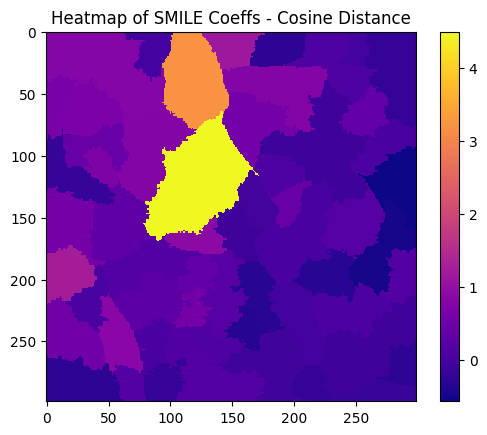

In [35]:
heat_mask_lime = create_heat_mask(superpixels, coeff)

plt.imshow(heat_mask_lime, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of SMILE Coeffs - Cosine Distance')
plt.show()


In [36]:
w_cov = get_weighted_coverage(heat_mask_lime, seman_transformed)
print("The weighted coverage of the heatmap with the true label is : ", w_cov)

The weighted coverage of the heatmap with the true label is :  0.45479981026825084


In [37]:
# Raise 
raise NotImplementedError

NotImplementedError: 

<a id="xwhy_wd"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Defining XWhy Function with Wasserstein Distance</b></div>

In [ ]:
def Wasserstein_Dist(XX, YY):
  
    import numpy as np
    nx = len(XX)
    ny = len(YY)
    n = nx + ny

    XY = np.concatenate([XX,YY])
    X2 = np.concatenate([np.repeat(1/nx, nx), np.repeat(0, ny)])
    Y2 = np.concatenate([np.repeat(0, nx), np.repeat(1/ny, ny)])

    S_Ind = np.argsort(XY)
    XY_Sorted = XY[S_Ind]
    X2_Sorted = X2[S_Ind]
    Y2_Sorted = Y2[S_Ind]

    Res = 0
    E_CDF = 0
    F_CDF = 0
    power = 1

    for ii in range(0, n-2):
        E_CDF = E_CDF + X2_Sorted[ii]
        F_CDF = F_CDF + Y2_Sorted[ii]
        height = abs(F_CDF-E_CDF)
        width = XY_Sorted[ii+1] - XY_Sorted[ii]
        Res = Res + (height ** power) * width;  
 
    return Res

def  Wasserstein_Dist_PVal(XX, YY):
    # Information about Bootstrap: 
    # https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60
    import random
    nboots = 1000
    WD = Wasserstein_Dist(XX,YY)
    na = len(XX)
    nb = len(YY)
    n = na + nb
    comb = np.concatenate([XX,YY])
    reps = 0
    bigger = 0
    for ii in range(1, nboots):
        e = random.sample(range(n), na)
        f = random.sample(range(n), nb)
        boost_WD = Wasserstein_Dist(comb[e],comb[f]);
        if (boost_WD > WD):
            bigger = 1 + bigger
            
    pVal = bigger/nboots;

    return pVal, WD

def Wasserstein_Dist_Image(img1, img2):
    if img1.shape[0] != img2.shape[0] or img1.shape[1] != img2.shape[1]:
        pritn('input images should have the same size')
    else:
        WD = []
        for ii in range(3):
            
            im1 = np.array(img1[:,:,ii].flatten())
            im2 = np.array(img2[:,:,ii].flatten())

            WD.append(Wasserstein_Dist(im1, im2))
            
    return sum(WD)
  
def xwhy_image_wd(X_input, model, num_perturb = 400, kernel_width = 0.25):
    
    superpixels = skimage.segmentation.quickshift(X_input, kernel_size=3, max_dist=200, ratio=0.25)
    num_superpixels = np.unique(superpixels).shape[0]
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    
    
    def perturb_image(img,perturbation,segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
              mask[segments == active] = 1 
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image
    
    predictions = None
    WD_dist = []
    for pert in tqdm(perturbations):
        perturbed_img = perturb_image(X_input,pert,superpixels)
        in_batch = preprocess_numpy(perturbed_img)
        with torch.no_grad():
            pred = model(in_batch)
        if predictions is None:
            predictions = pred.detach().cpu().unsqueeze(0).numpy()
        else:
            predictions = np.concatenate((predictions, pred.detach().cpu().unsqueeze(0).numpy()), 0)
        WD_dist.append(Wasserstein_Dist_Image(X_input, perturbed_img))
        
    WD_dist = np.array(WD_dist)
    
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    # distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    
    weights = np.sqrt(np.exp(-(WD_dist**2)/kernel_width**2)) #Kernel function
    
    class_to_explain = top5_catid[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
        
    return coeff

In [ ]:
%%time
coeff = xwhy_image_wd(Xi, model=model, num_perturb = 150, kernel_width = 0.25)
num_top_features = 4
# top_features = np.argsort(coeff)[-num_top_features:] 
top_features = np.argsort(coeff)[np.argsort(coeff) < num_superpixels][-num_top_features:] 
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels))

In [ ]:
a = perturb_image(Xi/2+0.5,mask,superpixels)
cov = get_coverage(a, seman_transformed)
print("The coverage with the true label is : ", cov)

<a id="comp_BayLIME"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Comparing XWhy with BayLIME</b></div>

In [ ]:
Xi_b = skimage.io.imread("/kaggle/input/baylimeimgex5/5.jpg")
Xi_b = skimage.transform.resize(Xi_b, (299,299)) 
Xi_b = (Xi_b - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi_b/2+0.5) # Show image before inception preprocessing

In [ ]:
image_annotated, sem_mask = get_annotations("/kaggle/input/baylimeimgex5/5.jpg", annotation_file)
seman_transformed = skimage.transform.resize(sem_mask, (299,299), preserve_range=True).astype('uint8')
im_np = np.array(image_annotated)
image_annotated = skimage.transform.resize(im_np, (299,299)) 
image_annotated = (image_annotated - 0.5)*2 #Inception pre-processing
skimage.io.imshow(image_annotated/2+0.5) # Show image before inception preprocessing

In [ ]:
in_batch = preprocess_numpy(Xi_b)
in_batch.shape

In [ ]:
in_batch = preprocess_numpy(Xi_b)
with torch.no_grad():
  output = model(in_batch)
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

In [ ]:
top5_prob_b, top_pred_classes_b = torch.topk(probabilities, 5)
for i in range(top5_prob_b.size(0)):
    print(categories[top_pred_classes_b[i]], top5_prob_b[i].item())

In [ ]:
superpixels_b = skimage.segmentation.quickshift(Xi_b, kernel_size=7,max_dist=100, ratio=0.2)
num_superpixels_b = np.unique(superpixels_b).shape[0]

print(num_superpixels_b)

skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi_b/2+0.5, superpixels_b))

In [ ]:
# superpixels = skimage.segmentation.quickshift(X_input, kernel_size=3, max_dist=200, ratio=0.25)
# num_superpixels = np.unique(superpixels).shape[0]
perturbations_b = np.random.binomial(1, 0.5, size=(200, num_superpixels_b))


def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
          mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

predictions = None
WD_dist = []
for pert in tqdm(perturbations_b):
    perturbed_img = perturb_image(Xi_b,pert,superpixels_b)
    in_batch = preprocess_numpy(perturbed_img)
    with torch.no_grad():
        pred = model(in_batch)
    if predictions is None:
        predictions = pred.detach().cpu().unsqueeze(0).numpy()
    else:
        predictions = np.concatenate((predictions, pred.detach().cpu().unsqueeze(0).numpy()), 0)
    WD_dist.append(Wasserstein_Dist_Image(Xi_b, perturbed_img))

WD_dist = np.array(WD_dist)

original_image = np.ones(num_superpixels_b)[np.newaxis,:] #Perturbation with all superpixels enabled 
# distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()

weights = np.sqrt(np.exp(-(WD_dist**2)/kernel_width**2)) #Kernel function

class_to_explain = top_pred_classes_b[0]
simpler_model_b = LinearRegression()
simpler_model_b.fit(X=perturbations_b, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff_b = simpler_model_b.coef_[0]

num_top_features = 1
top_features = np.argsort(coeff_b)[-num_top_features:] 
mask = np.zeros(num_superpixels_b) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi_b/2+0.5,mask,superpixels_b) )

In [ ]:
num_superpixels_b

In [ ]:
heat_mask_wd = create_heat_mask(superpixels_b, coeff_b)

plt.imshow(heat_mask_wd, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of SMILE Coeffs - WD')
plt.show()

In [ ]:
a = perturb_image(Xi_b/2+0.5,mask,superpixels_b)
cov = get_coverage(a, seman_transformed)
print("The coverage with the true label is : ", cov)

In [ ]:
w_cov = get_weighted_coverage(heat_mask_wd, seman_transformed)
print("The weighted coverage of the heatmap with the true label is : ", w_cov)

In [ ]:
comparison_dists = pd.DataFrame([['Wasserstein', cov, w_cov]], columns=['Distance', 'Simple Coverage', 'Weighted Coverage'])
comparison_dists

In [ ]:
comparison_others = pd.DataFrame([['SMILE', cov, w_cov]], columns=['XAI method', 'Simple Coverage', 'Weighted Coverage'])
comparison_others

<a id="LIME"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Comparing with LIME</b></div>

In [ ]:
def xwhy_image(X_input, model, num_perturb = 200, kernel_width = 0.25, top_pred_classes = top_pred_classes_b):
    
    superpixels = skimage.segmentation.quickshift(X_input, kernel_size=4, max_dist=200, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    
    def perturb_image(img,perturbation,segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
              mask[segments == active] = 1 
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image
    
    predictions = None
    for pert in tqdm(perturbations):
        perturbed_img = perturb_image(X_input,pert,superpixels)
        in_batch = preprocess_numpy(perturbed_img)
        with torch.no_grad():
            pred = model(in_batch)
        if predictions is None:
            predictions = pred.detach().cpu().unsqueeze(0).numpy()
        else:
            predictions = np.concatenate((predictions, pred.detach().cpu().unsqueeze(0).numpy()), 0)
    
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
        
    return coeff, perturbations

In [ ]:
%%time
coeff_lime, superpixels_lime = xwhy_image(Xi_b, model=model, num_perturb=200)

In [ ]:
num_top_features = 1
# top_features = np.argsort(coeff_lime)[-num_top_features:] 
top_features = np.argsort(coeff_lime)[np.argsort(coeff_lime) < num_superpixels_b][-num_top_features:] 
# mask = np.zeros(np.unique(superpixels_lime).shape[0]) 
mask = np.zeros(num_superpixels_b) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi_b/2+0.5,mask,superpixels_lime) )

In [ ]:
a = perturb_image(Xi_b/2+0.5,mask,superpixels_lime)
cov = get_coverage(a, seman_transformed)
print("The coverage with the true label is : ", cov)

In [ ]:
heat_mask_lime = create_heat_mask(superpixels_lime, coeff_lime)

plt.imshow(heat_mask_lime, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of SMILE Coeffs - Cosine Distance')
plt.show()

In [ ]:
w_cov = get_weighted_coverage(heat_mask_lime, seman_transformed)
print("The weighted coverage of the heatmap with the true label is : ", w_cov)

In [ ]:
comparison_others.loc[len(comparison_others)] = ['LIME', cov, w_cov]
comparison_others

In [ ]:
# Implemented only until here
raise NotImplementedError

<a id="comp_SHAP"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Comparing XWhy with Weak Implementation of SHAP</b></div>

In [ ]:
superpixels_b = skimage.segmentation.slic(Xi_b, n_segments=17, compactness=10, sigma=1,start_label=1)     
num_superpixels_b = np.unique(superpixels_b).shape[0]

print(num_superpixels_b)

skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi_b/2+0.5, superpixels_b))

In [ ]:
%%time
import sklearn

import scipy.special
import itertools

# SHAP Implementation from 
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Simple%20Kernel%20SHAP.html

def perturb_image(img,perturbation,segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
              mask[segments == active] = 1 
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image

def predict_proba_feature(X_input, perturbations):
#     perturb_prediction = []
#     for subset in perturbations:
#         data = sample * subset
#         perturb_prediction.append(np.max(model.predict(data)))
    perturb_prediction = []
    for pert in perturbations:
        perturbed_img = perturb_image(X_input,pert,superpixels)
        pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
        perturb_prediction.append(pred[0])

    return perturb_prediction

def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

def shapley_kernel(M,s):
    if s == 0 or s == M:
        return 10000
    return (M-1)/(scipy.special.binom(M,s)*s*(M-s))

def kernel_shap(f, x, reference, M, X_input):
    X = np.zeros((2**M,M+1))
    X[:,-1] = 1
    weights = np.zeros(2**M)
    V = np.zeros((2**M,M))
    for i in range(2**M):
        V[i,:] = reference

    for i,s in enumerate(powerset(range(M))):
        s = list(s)
        V[i,s] = x[s]
        X[i,s] = 1
        weights[i] = shapley_kernel(M,len(s))
    y = f(X_input, V)
    tmp = np.linalg.inv(np.dot(np.dot(X.T, np.diag(weights)), X))
    return np.dot(tmp, np.dot(np.dot(X.T, np.diag(weights)), y)) # Linear regression with kernel (weights)!


superpixels = skimage.segmentation.slic(Xi_b, n_segments=21, compactness=7, sigma=1,start_label=1)               
num_superpixels = np.unique(superpixels).shape[0]
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

M = num_superpixels
reference = np.zeros(M)
phi = kernel_shap(predict_proba_feature, np.ones(M), reference, M, Xi_b)
shap_values = phi[:-1]



In [ ]:
import pandas as pd
SHAP_df = pd.DataFrame(shap_values.T)
SHAP_df


In [ ]:
max_shap_values = np.max(shap_values, axis=1)
max_shap_values

In [ ]:
average_shap_values = np.mean(shap_values, axis=1)
average_shap_values

In [ ]:
num_top_features = 1
top_features = np.argsort(max_shap_values)[-num_top_features:] 
mask = np.zeros(np.unique(superpixels).shape[0]) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi_b/2+0.5,mask,superpixels))

In [ ]:
a = perturb_image(Xi_b/2+0.5,mask,superpixels)
cov = get_coverage(a, seman_transformed)
print("The coverage with the true label is : ", cov)

In [ ]:
heat_mask_shap = create_heat_mask(superpixels, max_shap_values)

plt.imshow(heat_mask_shap, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of SHAP Max. Values')
plt.show()

In [ ]:
w_cov = get_weighted_coverage(heat_mask_shap, seman_transformed)
print("The weighted coverage of the heatmap with the true label is : ", w_cov)

In this weak implementation of SHAP, only max shap values are considered. 

In [ ]:
comparison_others.loc[len(comparison_others)] = ['SHAP', cov, w_cov]
comparison_others

In [ ]:
num_top_features = 1
top_features = np.argsort(average_shap_values)[-num_top_features:] 
mask = np.zeros(np.unique(superpixels).shape[0]) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi_b/2+0.5,mask,superpixels))

In [ ]:
a = perturb_image(Xi_b/2+0.5,mask,superpixels)
cov = get_coverage(a, seman_transformed)
print("The coverage with the true label is : ", cov)

In [ ]:
heat_mask_shap2 = create_heat_mask(superpixels, average_shap_values)

plt.imshow(heat_mask_shap2, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of SHAP Avg. Values')
plt.show()

In [ ]:
w_cov = get_weighted_coverage(heat_mask_shap2, seman_transformed)
print("The weighted coverage of the heatmap with the true label is : ", w_cov)

<a id="comp_BayLIME_Weak"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Comparing XWhy with Weak Implementation of BayLIME</b></div>

In [ ]:
from sklearn.linear_model import BayesianRidge

def xwhy_BayLIME_image(X_input, model, num_perturb = 200, kernel_width = 0.25, top_pred_classes = top_pred_classes_b):
    
    superpixels = skimage.segmentation.quickshift(X_input, kernel_size=5, max_dist=200, ratio=0.2)
    
    num_superpixels = np.unique(superpixels).shape[0]
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    
    def perturb_image(img,perturbation,segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
            mask[segments == active] = 1 
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image
    
    predictions = []
    for pert in perturbations:
        perturbed_img = perturb_image(X_input,pert,superpixels)
        pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)

    predictions = np.array(predictions)
    
    original_image = np.ones(num_superpixels)[np.newaxis,:] 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2))
    
    class_to_explain = top_pred_classes[0]
    simpler_model = BayesianRidge()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain].ravel(), sample_weight=weights)
    coeff = simpler_model.coef_
        
    return coeff, superpixels

In [ ]:
%%time
coeff_BayLIME, superpixels_BayLIME = xwhy_BayLIME_image(Xi_b, model=inceptionV3_model)

num_top_features = 1
top_features = np.argsort(coeff_BayLIME)[-num_top_features:] 
mask = np.zeros(np.unique(superpixels_BayLIME).shape[0]) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi_b/2+0.5,mask,superpixels_BayLIME) )

In [ ]:
heat_mask_BayLIME = create_heat_mask(superpixels_BayLIME, coeff_BayLIME)

plt.imshow(heat_mask_BayLIME, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of SMILE Coeffs - Cosine Distance')
plt.show()

In [ ]:
a = perturb_image(Xi_b/2+0.5,mask,superpixels_BayLIME) 
cov = get_coverage(a, seman_transformed)
print("The coverage with the true label is : ", cov)

In [ ]:
w_cov = get_weighted_coverage(heat_mask_BayLIME, seman_transformed)
print("The weighted coverage of the heatmap with the true label is : ", w_cov)

In [ ]:
comparison_others.loc[len(comparison_others)] = ['Bay-LIME', cov, w_cov]
comparison_others

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(30, 30)) 

fz = 20

im = axs[0,0].imshow(heat_mask_lime, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[0,0])
cbar.ax.tick_params(labelsize=14)  
axs[0,0].set_title('Heatmap of LIME Coeffs - Cosine Distance', fontsize= fz)
axs[0,0].axis('off')

im = axs[0,1].imshow(heat_mask_k, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[0,1])
cbar.ax.tick_params(labelsize=14)  
axs[0,1].set_title('Heatmap of SMILE Coeffs - Kuiper Distance', fontsize= fz)
axs[0,1].axis('off')

im = axs[0,2].imshow(heat_mask_ks, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[0,2])
cbar.ax.tick_params(labelsize=14)  
axs[0,2].set_title('Heatmap of SMILE Coeffs - KSD', fontsize= fz)
axs[0,2].axis('off')

im = axs[1,0].imshow(heat_mask_wd, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[1,0])
cbar.ax.tick_params(labelsize=14)  
axs[1,0].set_title('Heatmap of SMILE Coeffs - WD', fontsize= fz)
axs[1,0].axis('off')

im = axs[1,1].imshow(heat_mask_ad, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[1,1])
cbar.ax.tick_params(labelsize=14)  
axs[1,1].set_title('Heatmap of SMILE Coeffs - ADD', fontsize= fz)
axs[1,1].axis('off')

im = axs[1,2].imshow(heat_mask_cvm, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[1,2])
cbar.ax.tick_params(labelsize=14)  
axs[1,2].set_title('Heatmap of SMILE Coeffs - CVMD', fontsize= fz)
axs[1,2].axis('off')

im = axs[2,0].imshow(heat_mask_BayLIME, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[2,0])
cbar.ax.tick_params(labelsize=14)  
axs[2,0].set_title('Heatmap of BayLIME Coeffs', fontsize= fz)
axs[2,0].axis('off')

im = axs[2,1].imshow(heat_mask_shap2, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[2,1])
cbar.ax.tick_params(labelsize=14)  
axs[2,1].set_title('Heatmap of SHAP Avg. Values', fontsize= fz)
axs[2,1].axis('off')

im = axs[2,2].imshow(heat_mask_shap, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[2,2])
cbar.ax.tick_params(labelsize=14)  
axs[2,2].set_title('Heatmap of SHAP Max Values', fontsize= fz)
axs[2,2].axis('off')

In [ ]:
plt.savefig('my_figure.png', dpi=300, bbox_inches='tight')

<a id = "ref"></a>
<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>References</b></div>

<div style="background-color:aliceblue; padding:30px; font-size:15px;color:#034914">
    
* [[Interpretable Machine Learning with LIME for Image Classification]](https://nbviewer.org/url/arteagac.github.io/blog/lime_image.ipynb) by Cristian Arteaga used for Step-by-step implementation of LIME and then the rest of the code was added as the contribution of [X-Why](https://github.com/Dependable-Intelligent-Systems-Lab/xwhy).
* [[LIME Paper:]](https://arxiv.org/abs/1602.04938) Ribeiro, M. T., Singh, S., & Guestrin, C. (2016, August). " Why should i trust you?" Explaining the predictions of any classifier. In Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining (pp. 1135-1144). [[LIME GitHub Repo]](https://github.com/marcotcr/lime).
* [[BayLIME Paper:]](https://proceedings.mlr.press/v161/zhao21a/zhao21a.pdf) Zhao, X., Huang, W., Huang, X., Robu, V., and Flynn, D. (2021, December). Baylime: Bayesian local interpretable model-agnostic explanations. In Uncertainty in artificial intelligence (pp. 887-896). PMLR. [[BayLIME GitHub Repo]](https://github.com/x-y-zhao/BayLime).
* [[SafeML Paper 1:]](https://arxiv.org/pdf/2005.13166.pdf) Aslansefat, K., Sorokos, I., Whiting, D., Tavakoli Kolagari, R., & Papadopoulos, Y. (2020). SafeML: safety monitoring of machine learning classifiers through statistical difference measures. In Model-Based Safety and Assessment: 7th International Symposium, IMBSA 2020, Lisbon, Portugal, September 14–16, 2020, Proceedings 7 (pp. 197-211). Springer International Publishing. [[SafeML GitHub Repo]](https://github.com/ISorokos/SafeML).
* [[SafeML Paper 2:]](https://bradscholars.brad.ac.uk/bitstream/handle/10454/18591/Abdullatif_ARA_2021.pdf?sequence=5) Aslansefat, K., Kabir, S., Abdullatif, A., Vasudevan, V., & Papadopoulos, Y. (2021). Toward improving confidence in autonomous vehicle software: A study on traffic sign recognition systems. Computer, 54(8), 66-76. [[SafeML GitHub Repo]](https://github.com/ISorokos/SafeML).   
* [🔥 EDA & ML on Game Play 🎮 (ongoing)](https://www.kaggle.com/code/nguyenthicamlai/eda-ml-on-game-play-ongoing) by [Nguyen Thi Cam Lai](https://www.kaggle.com/nguyenthicamlai) used for HTML-based headers

<center> <a href="#TOC" role="button" aria-pressed="true" >⬆️ Back to Table of Contents ⬆️</a>

<div style="border-radius:10px;border:#034914 solid;padding: 15px;background-color:aliceblue;font-size:90%;text-align:left">

<h4><b>Author :</b> Koorosh Aslansefat </h4>

<h4> <b>Some information:</b> </h4>

<b>👉Check my Kaggle Notebooks :</b> https://www.kaggle.com/kooaslansefat <br>
<b>👉Contact Me :</b> <a href="mailto:koo.ec2008@gmail.com">koo.ec2008@gmail.com</a><br>
<b>👉Find me LinkedIn :</b> www.linkedin.com/in/koorosh-aslansefat <br>
<b>👉Find me Github :</b> https://github.com/koo-ec <br>
    
    
<center> <strong> If you liked this Notebook, please do upvote. </strong>
    
<center> <strong> If you have any questions, feel free to contact me! </strong>
    
<center> <strong> ✨Best Wishes✨ </strong>

<center> <img src="https://gregcfuzion.files.wordpress.com/2022/01/kind-regards-2.png" style='width: 600px; height: 300px;'>